# 🦖 NEAT Training for Chrome Dino Game

**NEAT** = NeuroEvolution of Augmenting Topologies

### Network Architecture: 12 inputs → 2 outputs
| Layer | Nodes | Description |
|-------|-------|-------------|
| **Inputs** | 12 | Obstacle 1 (5), Obstacle 2 (3), Dino State (4) |
| **Outputs** | 2 | JUMP, DUCK (RUN is automatic/default) |

### Inputs Detail
| # | Input | Description |
|---|-------|-------------|
| 0-4 | **Obstacle 1** | Distance, Width, Height, Y, Is_Bird |
| 5-7 | **Obstacle 2** | Distance, Height, Is_Bird |
| 8-11 | **Dino State** | Y position, Velocity, Speed, Is_Ducking |

### Rewards & Penalties
| Type | Points | Description |
|------|--------|-------------|
| Obstacle passed | +10 | Per obstacle cleared |
| Survival | +0.1/frame | Staying alive |
| Score milestone | +12/100pts | Bonus every 100 score |
| Score milestone | +15/500pts | Bonus every 500 score |
| **Bird penalty** | **-30/frame** | Not ducking when low/mid bird is near (50-150px) |

In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# 1. 📦 IMPORTS & SETUP
# ═══════════════════════════════════════════════════════════════════════════════
import os, sys, pickle, importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sys.path.append(os.path.join(os.getcwd(), 'src'))
import neat
import neat_trainer
importlib.reload(neat_trainer)
from neat_trainer import create_config_file, NEATTrainer, NEATVisualTester

os.makedirs('models_state', exist_ok=True)
os.makedirs('plots_state', exist_ok=True)
print("✅ Imports loaded!")

✅ Imports loaded!


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# 2. ⚙️ CONFIGURATION - EDIT THESE VALUES!
# ═══════════════════════════════════════════════════════════════════════════════

POPULATION_SIZE = 100      # Dinos per generation
GENERATIONS = 1           # Generations to train
START_SPEED = 8          # Starting game speed (default=14, max=25) - higher = harder!
MUTATION_RATE = 0.75       # Weight/bias mutation rate (0.0-1.0, lower = more stable)
ELITISM = 25              # Top genomes preserved each generation (higher = safer)

# Create config file with specified parameters
config_path = create_config_file("neat_config.txt", 
                                  population_size=POPULATION_SIZE,
                                  mutation_rate=MUTATION_RATE,
                                  elitism=ELITISM)
print(f"⚙️ Pop: {POPULATION_SIZE} | Gens: {GENERATIONS} | Speed: {START_SPEED} | Mutation: {MUTATION_RATE} | Elitism: {ELITISM}")

✓ NEAT config created: neat_config.txt
⚙️ Pop: 100 | Gens: 1 | Speed: 8 | Mutation: 0.75 | Elitism: 25


## 3. 🆕 Fresh Training (Start from Scratch)

Deletes all previous models and starts training from a blank population.

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# 3. 🆕 FRESH TRAINING (Start from Scratch)
# ═══════════════════════════════════════════════════════════════════════════════
from datetime import datetime
import shutil

# Create prev_models folder
os.makedirs('prev_models', exist_ok=True)

# Move old models to prev_models (instead of deleting)
old_files = ['models_state/neat_winner.pkl', 
             'models_state/neat_interrupted.pkl',
             'models_state/neat_checkpoint.pkl',
             'models_state/neat_stats.pkl']

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print("📦 Backing up old models to prev_models/...")
for f in old_files:
    if os.path.exists(f):
        filename = os.path.basename(f)
        backup_name = f"prev_models/{timestamp}_{filename}"
        shutil.move(f, backup_name)
        print(f"   Moved: {f} → {backup_name}")

print(f"\n🆕 Starting FRESH Training - {GENERATIONS} generations @ speed {START_SPEED}")
print("="*60)

# Reload module to get latest code
importlib.reload(neat_trainer)
from neat_trainer import NEATTrainer

# Create trainer from scratch with configurable start speed
trainer = NEATTrainer("neat_config.txt", render=True, start_speed=START_SPEED)

try:
    winner = trainer.run(generations=GENERATIONS)
    
    # Save winner
    trainer.save_winner('models_state/neat_winner.pkl', winner)
    trainer.save_checkpoint('models_state/neat_checkpoint.pkl')
    
    # Save stats
    with open('models_state/neat_stats.pkl', 'wb') as f:
        pickle.dump({
            'best_scores': trainer.gen_best_scores,
            'avg_scores': trainer.gen_avg_scores,
            'generations': trainer.generation
        }, f)
    
    print(f"\n🏆 Training Complete!")
    print(f"   Winner Fitness: {winner.fitness:.0f}")
    print(f"   Best Ever: {trainer.best_fitness:.0f}")

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted!")
    if trainer.best_genome:
        trainer.save_winner('models_state/neat_winner.pkl', trainer.best_genome)
        trainer.save_checkpoint('models_state/neat_checkpoint.pkl')
        with open('models_state/neat_stats.pkl', 'wb') as f:
            pickle.dump({
                'best_scores': trainer.gen_best_scores,
                'avg_scores': trainer.gen_avg_scores,
                'generations': trainer.generation
            }, f)
        print(f"   Saved best (fitness: {trainer.best_fitness:.0f})")

finally:
    trainer.close()
    print("✅ Done")

📦 Backing up old models to prev_models/...
   Moved: models_state/neat_winner.pkl → prev_models/20251128_014914_neat_winner.pkl
   Moved: models_state/neat_checkpoint.pkl → prev_models/20251128_014914_neat_checkpoint.pkl
   Moved: models_state/neat_stats.pkl → prev_models/20251128_014914_neat_stats.pkl

🆕 Starting FRESH Training - 1 generations @ speed 8
✓ Loaded original Chrome Dino sprites!

🧬 Starting NEAT Evolution for 1 generations...
   Population: 100
   Inputs: 8 | Outputs: 3
✓ Loaded original Chrome Dino sprites!

🧬 Starting NEAT Evolution for 1 generations...
   Population: 100
   Inputs: 8 | Outputs: 3
  Gen   1 | Best:   275 | Avg:    28 | Best Ever:   275 | Species: 1 | 20.6s ⭐NEW BEST!

🏆 Evolution Complete!
   Best Fitness: 275
   Nodes: 2
   Connections: 24
✓ Winner saved to models_state/neat_winner.pkl
✓ Checkpoint saved to models_state/neat_checkpoint.pkl

🏆 Training Complete!
   Winner Fitness: 275
   Best Ever: 275
✅ Done
  Gen   1 | Best:   275 | Avg:    28 | Best 

## 4. 🔄 Resume Training (Visual)

Continue training from your saved model with visualization.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 4. 🔄 RESUME TRAINING (Visual)
# ═══════════════════════════════════════════════════════════════════════════════

# How many more generations?
RESUME_GENERATIONS = 20

# Find saved model
model_path = None
stats_path = 'models_state/neat_stats.pkl'
if os.path.exists('models_state/neat_winner.pkl'):
    model_path = 'models_state/neat_winner.pkl'
elif os.path.exists('models_state/neat_interrupted.pkl'):
    model_path = 'models_state/neat_interrupted.pkl'

if model_path:
    # Load previous generation count
    prev_gen = 0
    if os.path.exists(stats_path):
        with open(stats_path, 'rb') as f:
            prev_stats = pickle.load(f)
            prev_gen = prev_stats.get('generations', 0)
    
    print(f"🔄 Resuming from: {model_path}")
    print(f"   Starting at Gen {prev_gen + 1}, training {RESUME_GENERATIONS} more (visual) @ speed {START_SPEED}")
    print("="*60)
    
    # Reload module
    importlib.reload(neat_trainer)
    from neat_trainer import NEATTrainer
    
    trainer = NEATTrainer.from_winner(model_path, "neat_config.txt", render=True, 
                                       start_speed=START_SPEED, stats_path=stats_path)
    
    try:
        winner = trainer.run(generations=RESUME_GENERATIONS)
        
        # Save
        trainer.save_winner('models_state/neat_winner.pkl', winner)
        trainer.save_checkpoint('models_state/neat_checkpoint.pkl')
        with open('models_state/neat_stats.pkl', 'wb') as f:
            pickle.dump({
                'best_scores': trainer.gen_best_scores,
                'avg_scores': trainer.gen_avg_scores,
                'generations': trainer.generation
            }, f)
        
        print(f"\n🏆 Training Complete!")
        print(f"   Generations: {prev_gen + 1} → {trainer.generation}")
        print(f"   Winner Fitness: {winner.fitness:.0f}")
        print(f"   Best Ever: {trainer.best_fitness:.0f}")
    
    except KeyboardInterrupt:
        print("\n⚠️ Interrupted!")
        if trainer.best_genome:
            trainer.save_winner('models_state/neat_winner.pkl', trainer.best_genome)
            trainer.save_checkpoint('models_state/neat_checkpoint.pkl')
            with open('models_state/neat_stats.pkl', 'wb') as f:
                pickle.dump({
                    'best_scores': trainer.gen_best_scores,
                    'avg_scores': trainer.gen_avg_scores,
                    'generations': trainer.generation
                }, f)
            print(f"   Saved at Gen {trainer.generation} (fitness: {trainer.best_fitness:.0f})")
    
    finally:
        trainer.close()
        print("✅ Done")
else:
    print("❌ No saved model found! Run Fresh Training first.")

## 5. 🚀 Resume Training (Headless - Faster!)

Continue training without visualization - much faster!

In [30]:
# ═══════════════════════════════════════════════════════════════════════════════
# 5. 🚀 RESUME TRAINING (Headless - FAST!)
# ═══════════════════════════════════════════════════════════════════════════════

# How many more generations? (can do more since it's faster!)
HEADLESS_GENERATIONS = 800
HEADLESS_POPULATION = 500  # Number of dinos for headless training
HEADLESS_START_SPEED = 18  # Starting speed for headless training (can be different!)
HEADLESS_MUTATION_RATE = 0.75  # Mutation rate for headless training
HEADLESS_ELITISM = 25         # Elitism for headless training

# Find saved model
model_path = None
stats_path = 'models_state/neat_stats.pkl'
if os.path.exists('models_state/neat_winner.pkl'):
    model_path = 'models_state/neat_winner.pkl'
elif os.path.exists('models_state/neat_interrupted.pkl'):
    model_path = 'models_state/neat_interrupted.pkl'

if model_path:
    # Load previous generation count
    prev_gen = 0
    if os.path.exists(stats_path):
        with open(stats_path, 'rb') as f:
            prev_stats = pickle.load(f)
            prev_gen = prev_stats.get('generations', 0)
    
    print(f"🚀 Headless Training from: {model_path}")
    print(f"   Starting at Gen {prev_gen + 1} | Pop: {HEADLESS_POPULATION} | Gens: {HEADLESS_GENERATIONS}")
    print(f"   Speed: {HEADLESS_START_SPEED} | Mutation: {HEADLESS_MUTATION_RATE} | Elitism: {HEADLESS_ELITISM}")
    print("="*60)
    
    # Reload module
    importlib.reload(neat_trainer)
    from neat_trainer import NEATTrainer, create_config_file
    
    # Recreate config with headless parameters
    create_config_file("neat_config.txt", 
                       population_size=HEADLESS_POPULATION,
                       mutation_rate=HEADLESS_MUTATION_RATE,
                       elitism=HEADLESS_ELITISM)
    
    trainer = NEATTrainer.from_winner(model_path, "neat_config.txt", render=False, 
                                       start_speed=HEADLESS_START_SPEED, stats_path=stats_path)
    
    try:
        winner = trainer.run(generations=HEADLESS_GENERATIONS)
        
        # Save
        trainer.save_winner('models_state/neat_winner.pkl', winner)
        trainer.save_checkpoint('models_state/neat_checkpoint.pkl')
        with open('models_state/neat_stats.pkl', 'wb') as f:
            pickle.dump({
                'best_scores': trainer.gen_best_scores,
                'avg_scores': trainer.gen_avg_scores,
                'generations': trainer.generation
            }, f)
        
        print(f"\n🏆 Headless Training Complete!")
        print(f"   Generations: {prev_gen + 1} → {trainer.generation}")
        print(f"   Winner Fitness: {winner.fitness:.0f}")
        print(f"   Best Ever: {trainer.best_fitness:.0f}")
    
    except KeyboardInterrupt:
        print("\n⚠️ Interrupted!")
        if trainer.best_genome:
            trainer.save_winner('models_state/neat_winner.pkl', trainer.best_genome)
            trainer.save_checkpoint('models_state/neat_checkpoint.pkl')
            with open('models_state/neat_stats.pkl', 'wb') as f:
                pickle.dump({
                    'best_scores': trainer.gen_best_scores,
                    'avg_scores': trainer.gen_avg_scores,
                    'generations': trainer.generation
                }, f)
            print(f"   Saved at Gen {trainer.generation} (fitness: {trainer.best_fitness:.0f})")
    
    finally:
        trainer.close()
        print("✅ Done")
else:
    print("❌ No saved model found! Run Fresh Training first.")

🚀 Headless Training from: models_state/neat_winner.pkl
   Starting at Gen 62 | Pop: 500 | Gens: 800
   Speed: 18 | Mutation: 0.75 | Elitism: 25
✓ NEAT config created: neat_config.txt
✓ Restored stats from: models_state/neat_stats.pkl
   Resuming from generation 61
⏳ Creating 500 genomes from winner...
⏳ Speciation...
✓ Loaded winner from: models_state/neat_winner.pkl
   Winner Fitness: 3424
   Created 500 genomes (50% copies, 50% mutations)

🧬 Starting NEAT Evolution for 800 generations...
   Population: 500
   Start Speed: 18
⏳ Speciation...
✓ Loaded winner from: models_state/neat_winner.pkl
   Winner Fitness: 3424
   Created 500 genomes (50% copies, 50% mutations)

🧬 Starting NEAT Evolution for 800 generations...
   Population: 500
   Start Speed: 18
  Gen  62 | Best:  2349 | Avg:   306 | Best Ever:  3424 | Species: 1 | 16.3s
  Gen  62 | Best:  2349 | Avg:   306 | Best Ever:  3424 | Species: 1 | 16.3s
  Gen  63 | Best:  2395 | Avg:   221 | Best Ever:  3424 | Species: 1 | 12.7s
  Gen 

c:\Users\IC1807\anaconda3\envs\DINO_TF\Lib\site-packages\neat\genome.py:297: RuntimeWarning: Innovation number collision: innovation 147 assigned to both (277, 227) and (-3, 326). Treating as disjoint genes.
  warnings.warn(
c:\Users\IC1807\anaconda3\envs\DINO_TF\Lib\site-packages\neat\genome.py:297: RuntimeWarning: Innovation number collision: innovation 147 assigned to both (-3, 326) and (277, 227). Treating as disjoint genes.
  warnings.warn(


  Gen  64 | Best:  1816 | Avg:   170 | Best Ever:  3424 | Species: 1 | 8.9s
  Gen  65 | Best:   733 | Avg:   190 | Best Ever:  3424 | Species: 1 | 9.3s
  Gen  65 | Best:   733 | Avg:   190 | Best Ever:  3424 | Species: 1 | 9.3s
  Gen  66 | Best:  2625 | Avg:   129 | Best Ever:  3424 | Species: 1 | 6.1s
  Gen  66 | Best:  2625 | Avg:   129 | Best Ever:  3424 | Species: 1 | 6.1s
  Gen  67 | Best:  1785 | Avg:   101 | Best Ever:  3424 | Species: 1 | 4.5s
  Gen  67 | Best:  1785 | Avg:   101 | Best Ever:  3424 | Species: 1 | 4.5s
  Gen  68 | Best:   722 | Avg:    56 | Best Ever:  3424 | Species: 1 | 2.1s
  Gen  68 | Best:   722 | Avg:    56 | Best Ever:  3424 | Species: 1 | 2.1s
  Gen  69 | Best:  1864 | Avg:    59 | Best Ever:  3424 | Species: 1 | 1.8s
  Gen  69 | Best:  1864 | Avg:    59 | Best Ever:  3424 | Species: 1 | 1.8s
  Gen  70 | Best:   359 | Avg:    72 | Best Ever:  3424 | Species: 1 | 2.0s
  Gen  70 | Best:   359 | Avg:    72 | Best Ever:  3424 | Species: 1 | 2.0s
  Gen  71 | 

## 6. 📊 Results Visualization

View training progress and test the trained model.

C:\Users\IC1807\AppData\Local\Temp\ipykernel_56228\1782451223.py:30: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.savefig('plots_state/neat_fitness_per_gen.png', dpi=150)


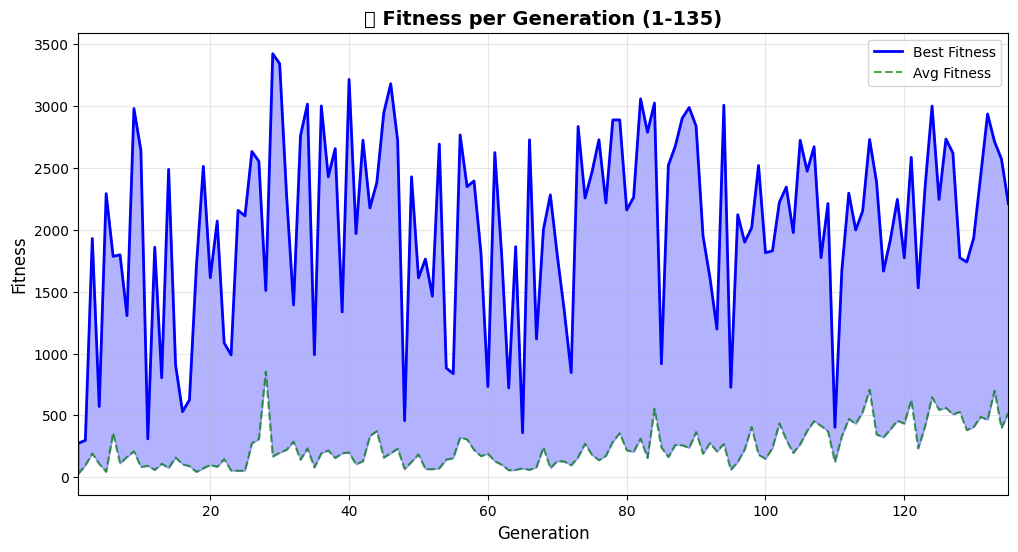

C:\Users\IC1807\AppData\Local\Temp\ipykernel_56228\1782451223.py:42: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig('plots_state/neat_best_over_time.png', dpi=150)


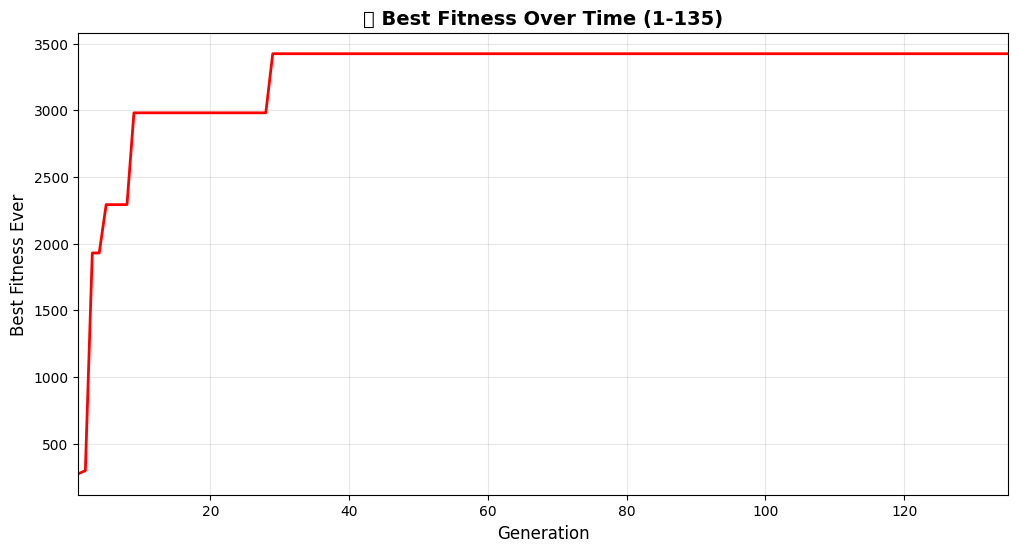

C:\Users\IC1807\AppData\Local\Temp\ipykernel_56228\1782451223.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('plots_state/neat_avg_trend.png', dpi=150)


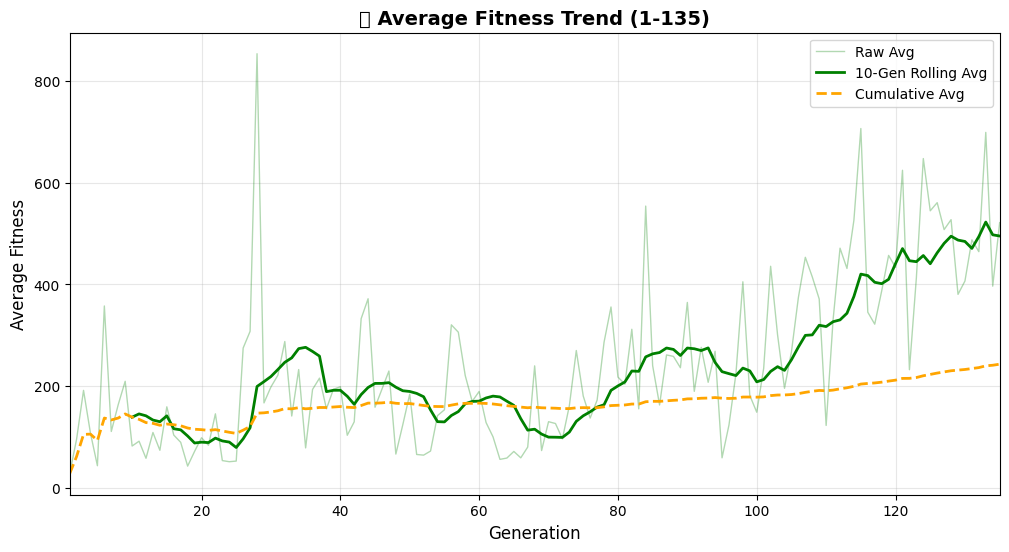

📊 Total Generations Trained: 135
🏆 Best Fitness Ever: 3424
📈 Latest Avg Fitness: 521
📈 All-Time Cumulative Avg: 243
📉 First Avg Fitness: 28
✓ Plots saved to plots_state/


In [31]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6. 📊 TRAINING PROGRESS PLOT
# ═══════════════════════════════════════════════════════════════════════════════

# Load stats
try:
    with open('models_state/neat_stats.pkl', 'rb') as f:
        stats = pickle.load(f)
    best_scores = stats['best_scores']
    avg_scores = stats['avg_scores']
    total_gens = stats.get('generations', len(best_scores))
except FileNotFoundError:
    print("❌ No stats file found! Run training first.")
    best_scores, avg_scores = [], []

if best_scores:
    generations = range(1, len(best_scores) + 1)
    
    # Plot 1: Fitness per generation
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(generations, best_scores, 'b-', lw=2, label='Best Fitness')
    ax1.plot(generations, avg_scores, 'g--', alpha=0.7, label='Avg Fitness')
    ax1.fill_between(generations, avg_scores, best_scores, alpha=0.3, color='blue')
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Fitness', fontsize=12)
    ax1.set_title(f'🧬 Fitness per Generation (1-{len(best_scores)})', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1, len(best_scores))
    plt.savefig('plots_state/neat_fitness_per_gen.png', dpi=150)
    plt.show()
    
    # Plot 2: Best fitness over time (cumulative max)
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    cumulative_best = np.maximum.accumulate(best_scores)
    ax2.plot(generations, cumulative_best, 'r-', lw=2)
    ax2.set_xlabel('Generation', fontsize=12)
    ax2.set_ylabel('Best Fitness Ever', fontsize=12)
    ax2.set_title(f'🏆 Best Fitness Over Time (1-{len(best_scores)})', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1, len(best_scores))
    plt.savefig('plots_state/neat_best_over_time.png', dpi=150)
    plt.show()
    
    # Plot 3: Average fitness trend
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    window = min(10, len(avg_scores))
    rolling_avg = np.convolve(avg_scores, np.ones(window)/window, mode='valid')
    rolling_gens = range(window, len(avg_scores) + 1)
    
    ax3.plot(generations, avg_scores, 'g-', alpha=0.3, lw=1, label='Raw Avg')
    ax3.plot(rolling_gens, rolling_avg, 'g-', lw=2, label=f'{window}-Gen Rolling Avg')
    cumulative_avg = np.cumsum(avg_scores) / np.arange(1, len(avg_scores) + 1)
    ax3.plot(generations, cumulative_avg, 'orange', lw=2, linestyle='--', label='Cumulative Avg')
    ax3.set_xlabel('Generation', fontsize=12)
    ax3.set_ylabel('Average Fitness', fontsize=12)
    ax3.set_title(f'📈 Average Fitness Trend (1-{len(best_scores)})', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(1, len(best_scores))
    plt.savefig('plots_state/neat_avg_trend.png', dpi=150)
    plt.show()
    
    print(f"📊 Total Generations Trained: {len(best_scores)}")
    print(f"🏆 Best Fitness Ever: {max(best_scores):.0f}")
    print(f"📈 Latest Avg Fitness: {avg_scores[-1]:.0f}")
    print(f"📈 All-Time Cumulative Avg: {np.mean(avg_scores):.0f}")
    print(f"📉 First Avg Fitness: {avg_scores[0]:.0f}")
    print("✓ Plots saved to plots_state/")

## 6b. 🎮 Test the Winner

Watch your trained Dino play!

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6b. 🎮 TEST THE WINNER
# ═══════════════════════════════════════════════════════════════════════════════

# Number of test games
NUM_TEST_GAMES = 5

# Reload module
importlib.reload(neat_trainer)
from neat_trainer import NEATVisualTester

# Load config
config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    "neat_config.txt"
)

# Load winner
try:
    with open('models_state/neat_winner.pkl', 'rb') as f:
        winner = pickle.load(f)
    
    print("🎮 Testing Winner")
    print("="*50)
    print(f"   Fitness: {winner.fitness:.0f}")
    print(f"   Nodes: {len(winner.nodes)}")
    print(f"   Connections: {len([c for c in winner.connections.values() if c.enabled])}")
    
    print(f"\n🦖 Watch the evolved Dino play {NUM_TEST_GAMES} games!")
    tester = NEATVisualTester(winner, config)
    test_scores = tester.run(num_games=NUM_TEST_GAMES)
    
    print(f"\n📊 Test Results:")
    print(f"   Average: {np.mean(test_scores):.0f}")
    print(f"   Best:    {max(test_scores)}")
    print(f"   Worst:   {min(test_scores)}")
    
except FileNotFoundError:
    print("❌ No winner found! Run training first.")

## 7. 🧬 Network Topology Visualization

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 7. 🧬 NETWORK TOPOLOGY VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

try:
    with open('models_state/neat_winner.pkl', 'rb') as f:
        winner = pickle.load(f)
except FileNotFoundError:
    print("❌ No winner found!")
    winner = None

if winner:
    # Debug: Print actual connection keys to understand structure
    print("🔍 DEBUG: Connection structure")
    enabled_connections = [(k, v) for k, v in winner.connections.items() if v.enabled]
    print(f"   Enabled connections: {len(enabled_connections)}")
    for (i_n, o_n), conn in enabled_connections[:10]:  # Show first 10
        print(f"   {i_n} → {o_n} (weight: {conn.weight:.2f})")
    
    print(f"\n   Output node keys: {list(winner.nodes.keys())}")
    
    # NEAT uses -1 to -N for inputs (not -N to -1)
    # Input -1 = first input, -2 = second input, etc.
    input_keys = list(range(-1, -13, -1))  # [-1, -2, -3, ..., -12]
    output_keys = [0, 1]  # Only 2 outputs now: JUMP, DUCK
    input_names = ['O1_Dist', 'O1_Width', 'O1_Height', 'O1_Y', 'O1_Bird',  # Obstacle 1
                   'O2_Dist', 'O2_Height', 'O2_Bird',                       # Obstacle 2
                   'Dino_Y', 'Velocity', 'Speed', 'Is_Duck']               # Dino state
    output_names = ['JUMP', 'DUCK']  # RUN is automatic (default)
    
    hidden_keys = [k for k in winner.nodes.keys() if k not in output_keys]
    hidden_count = len(hidden_keys)
    
    print(f"\n🧬 Network: 12 → {hidden_count} → 2 | {len(enabled_connections)} connections | Fitness: {winner.fitness:.0f}")
    
    fig_height = max(12, 2 + hidden_count * 0.4)
    fig, ax = plt.subplots(1, 1, figsize=(16, fig_height))
    max_y = max(12, hidden_count) + 1
    ax.set_xlim(-1, 5); ax.set_ylim(-1, max_y + 1); ax.axis('off')
    ax.set_title('🧬 Evolved NEAT Network (12 inputs → 2 outputs: JUMP/DUCK)', fontsize=16, fontweight='bold', pad=20)
    
    # Position all nodes
    node_positions = {}
    
    # Input nodes (y positions spaced evenly)
    for i, key in enumerate(input_keys):
        node_positions[key] = (0, max_y - 1 - i * (max_y / 12))
    
    # Hidden nodes
    if hidden_count > 0:
        if hidden_count <= 10:
            for i, key in enumerate(hidden_keys):
                node_positions[key] = (2, max_y - 1 - i * (max_y / max(hidden_count, 1)))
        else:
            cols = 2 if hidden_count <= 20 else 3
            npc = (hidden_count + cols - 1) // cols
            for i, key in enumerate(hidden_keys):
                node_positions[key] = (1.5 + (i // npc) * 0.8, max_y - 1 - (i % npc) * (max_y / npc))
    
    # Output nodes (2 outputs now)
    for i, key in enumerate(output_keys):
        node_positions[key] = (4, max_y - 3 - i * 6)  # Spaced for 2 outputs
    
    # Draw connections
    drawn_count = 0
    for (i_n, o_n), conn in enabled_connections:
        if i_n in node_positions and o_n in node_positions:
            x1, y1 = node_positions[i_n]
            x2, y2 = node_positions[o_n]
            w = conn.weight
            c = (0, min(1, abs(w)/5), 0, 0.6) if w > 0 else (min(1, abs(w)/5), 0, 0, 0.6)
            ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                       arrowprops=dict(arrowstyle='->', color=c, lw=min(3, 0.5 + abs(w) * 0.5), connectionstyle='arc3,rad=0.1'))
            drawn_count += 1
    
    print(f"   Drew {drawn_count}/{len(enabled_connections)} connections")
    
    # Draw input nodes
    for i, key in enumerate(input_keys):
        x, y = node_positions[key]
        if i < 5:
            color = '#3498db'  # Blue - Obstacle 1
        elif i < 8:
            color = '#1abc9c'  # Teal - Obstacle 2
        else:
            color = '#e67e22'  # Orange - Dino state
        ax.add_patch(plt.Circle((x, y), 0.2, color=color, ec='black', lw=2, zorder=5))
        ax.text(x - 0.35, y, input_names[i], ha='right', va='center', fontsize=9, fontweight='bold')
    
    # Draw hidden nodes
    for key in hidden_keys:
        x, y = node_positions[key]
        ax.add_patch(plt.Circle((x, y), 0.18, color='#9b59b6', ec='black', lw=1.5, zorder=5))
        ax.text(x, y, str(key), ha='center', va='center', fontsize=7, color='white')
    
    # Draw output nodes
    for i, key in enumerate(output_keys):
        x, y = node_positions[key]
        ax.add_patch(plt.Circle((x, y), 0.25, color='#e74c3c', ec='black', lw=2, zorder=5))
        ax.text(x + 0.4, y, output_names[i], ha='left', va='center', fontsize=10, fontweight='bold')
    
    ax.text(0, max_y + 0.5, 'INPUTS (12)', ha='center', fontsize=12, fontweight='bold', color='#3498db')
    ax.text(2, max_y + 0.5, 'HIDDEN', ha='center', fontsize=12, fontweight='bold', color='#9b59b6')
    ax.text(4, max_y + 0.5, 'OUTPUTS (2)', ha='center', fontsize=12, fontweight='bold', color='#e74c3c')
    ax.text(-0.5, -0.5, '🔵 Obstacle 1  🟢 Obstacle 2  🟠 Dino State  |  RUN = default (no output needed)', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('plots_state/neat_network_topology.png', dpi=150, bbox_inches='tight')
    plt.show()